Link: https://github.com/jakizao/Data_Science_Mini_Project/blob/899ff255a708bc367ffd84e191c6f081251aa9f8/Mini_Project_DS_C728YPL14.ipynb

Importing all important libraries and functions.

In [142]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as sm
import statsmodels.stats.api as sms
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import OLSInfluence
# setting the seed for reproduction 
np.random.seed(420)

Question 1: 

In [143]:
# Data Generation 

duration_ms = 5000

neuron_a = np.arange(10,duration_ms + 1,10) 
noise_neuron_b = np.random.normal(0,2,len(neuron_a))
neuron_b = neuron_a + noise_neuron_b 

# Plausability check: neuron b must be monotonically increasing => biologically not possible to fire at 20 and then at 15 
isi_check_b = neuron_b[1:] - neuron_b[:-1]
plausible_biologically = (isi_check_b > 0).all()
if plausible_biologically: 
    print("Pass: The firing pattern of neuron b is biologically plausible.")
else:
    print("Fail: The firing pattern of neuron b is biologically not plausible and needs to be fixed.")

# Neuron c 

# same pattern 1 51 101... as starting points ==> then 0,1,2 added 
starting_points = np.arange(1,duration_ms + 1,50) 
# three point burst 
burst_offset = [0,1,2] 
# to use broadcasting ==> (200,1) + (3,)   ==> stretches to (200,3) + (200,3)
bursting_indices_2dim = starting_points[:, np.newaxis] + burst_offset 
# return to vector/array format
neuron_c = bursting_indices_2dim.flatten() 

Pass: The firing pattern of neuron b is biologically plausible.


In [144]:
# binning of responses 
def bin_spikes(spike_times, duration_ms=5000):
   
    binary_vector = np.zeros(duration_ms) # 5000 zeros => later 1 or 0
    
    indices = spike_times.astype(int) # indices of when it was fired 10.7 => 10
    
    valid_indices = indices[(indices >= 0) & (indices < duration_ms)]
    
    binary_vector[valid_indices] = 1 # bins set to 1 when there was a spike 
    
    return binary_vector

binned_a = bin_spikes(neuron_a)
binned_b = bin_spikes(neuron_b)
binned_c = bin_spikes(neuron_c)

print(f"Binned Neuron A (first 20ms): {binned_a[:20]}")
# to get the indices of firing 
spikes_in_bins_a = np.where(binned_a == 1)[0] 
spikes_in_bins_b = np.where(binned_b == 1)[0] 
spikes_in_bins_c = np.where(binned_c == 1)[0]

Binned Neuron A (first 20ms): [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


Visualizing the Spike Trains

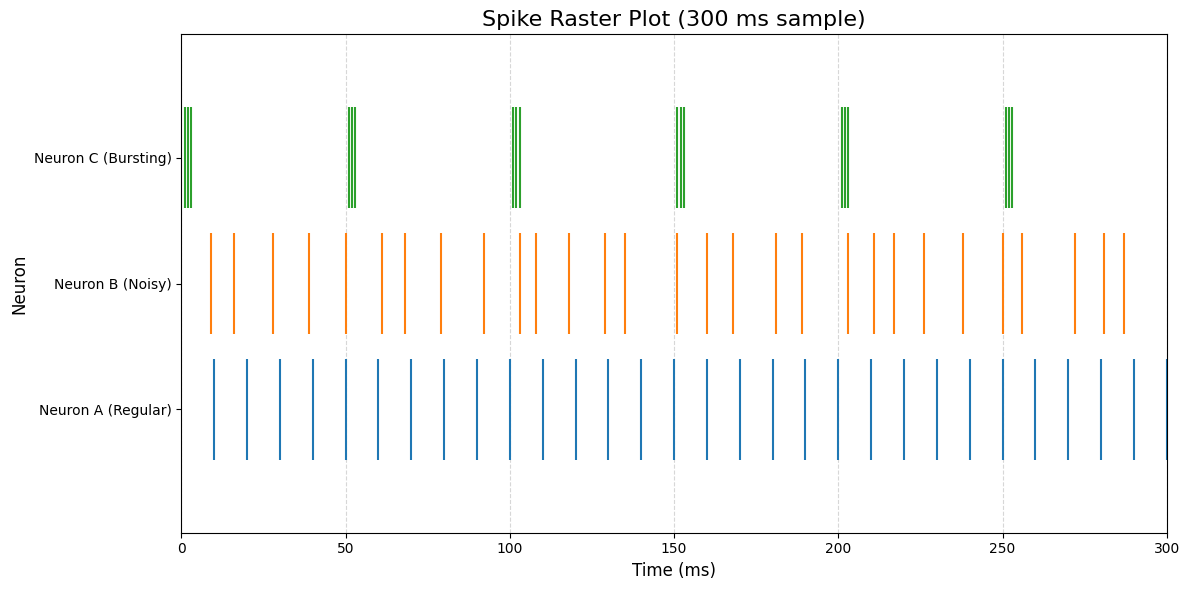

In [145]:
plt.figure(figsize=(12, 6))

neurons = [spikes_in_bins_a, spikes_in_bins_b, spikes_in_bins_c]
colors_neurons = ["C0", "C1", "C2"] # different colors 
labels = ["Neuron A (Regular)", "Neuron B (Noisy)", "Neuron C (Bursting)"]
plt.eventplot(neurons, orientation="horizontal", linelengths=0.8, colors=colors_neurons)

# Formatting the plot
plt.title("Spike Raster Plot (300 ms sample)", fontsize=16)
plt.xlabel("Time (ms)", fontsize=12)
plt.ylabel("Neuron", fontsize=12)
plt.yticks([0, 1, 2], labels)
plt.xlim(0, 300) 
# I only focus on the first 300 ms as the pattern is expected to be the same over the whole period and focusing on a sample allows one to actually see 
# small differences, which would otherwise be lost when the x-axis has to fit 5000 ms instead of only 300ms.

# Ensuring that it is easier to read
plt.grid(True, axis="x", alpha=0.5, linestyle="--")
plt.tight_layout()

plt.show()



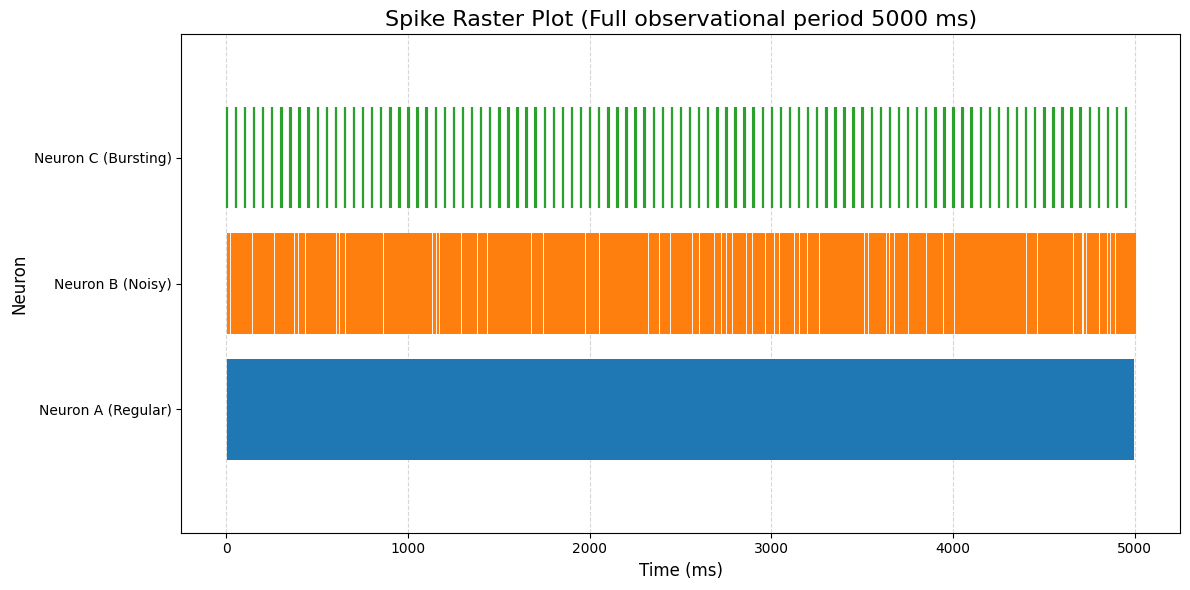

In [171]:
plt.figure(figsize=(12, 6))

neurons = [spikes_in_bins_a, spikes_in_bins_b, spikes_in_bins_c]
colors_neurons = ["C0", "C1", "C2"] # different colors 
labels = ["Neuron A (Regular)", "Neuron B (Noisy)", "Neuron C (Bursting)"]
plt.eventplot(neurons, orientation="horizontal", linelengths=0.8, colors=colors_neurons)

# Formatting the plot
plt.title("Spike Raster Plot (Full observational period 5000 ms)", fontsize=16)
plt.xlabel("Time (ms)", fontsize=12)
plt.ylabel("Neuron", fontsize=12)
plt.yticks([0, 1, 2], labels)


# Ensuring that it is easier to read
plt.grid(True, axis="x", alpha=0.5, linestyle="--")
plt.tight_layout()

plt.show()

Focusing on the 300 ms sample: The raster plots clearly reflect the firing patterns that we defined when generating the spike trains. Neuron A shows a perfectly regular firing pattern, with evenly spaced spikes throughout the entire observational period (as expected for a neuron without noise). Neuron B firing rate also seems to be roughly following a pattern, but its spike times exhibit small temporal fluctuations due to the added Gaussian noise, resulting in slightly irregular spike spacing that resembles biological variability. In contrast, Neuron C displays a clear bursting pattern, characterized by clusters of closely spaced spikes followed by longer silent intervals, thus firing fully deterministc (as expected for a neuron without any noise). Overall, the visualized spike trains match the expected behavior of regular, noisy, and bursting neurons.

Inter-Spike-Intervals

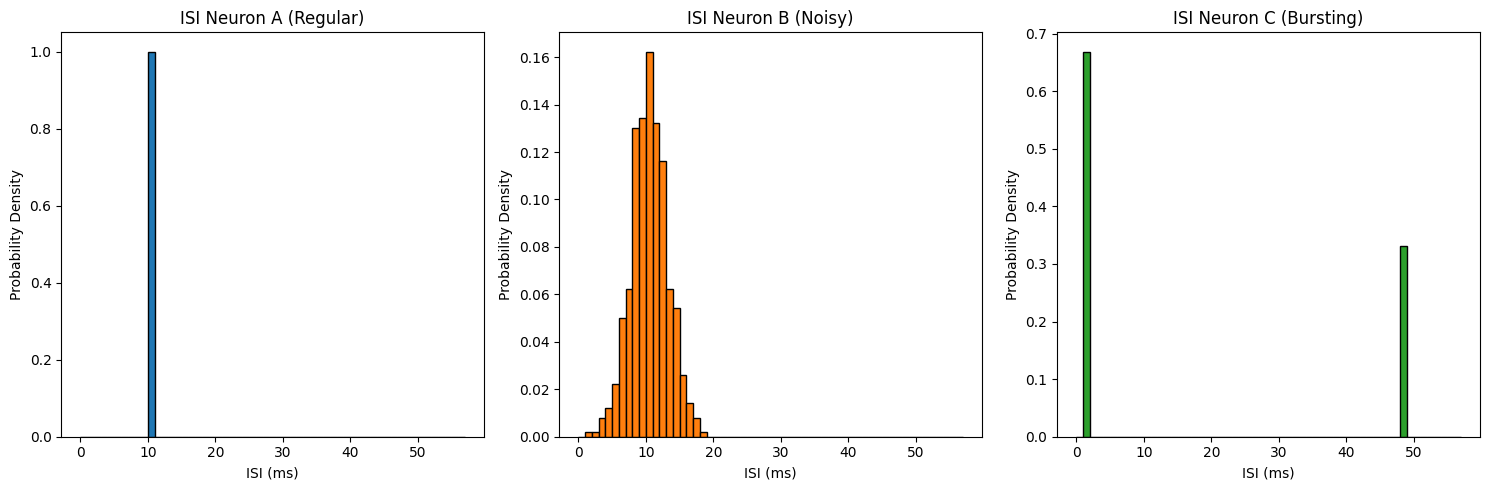

In [146]:
 #inter spike interval basically just neuron[1:]-neuron[:-1]  => does not caluclate first minus first or last minus last
# function to get all isi for all neurons at once 
def get_all_isi(neurons):
    all_intervals = []  
    
    for elements in neurons:
        isi = elements[1:] - elements[:-1] 
        # append the isi for current neuron in elements 
        all_intervals.append(isi)
        
    return all_intervals 

neuron_a_isi, neuron_b_isi, neuron_c_isi = get_all_isi(neurons) # must match exactly  

# histograms 
# get the largest isi for all neurons => for x axis max to allow comparisonsof spread
max_val = max(np.max(neuron_a_isi), np.max(neuron_b_isi), np.max(neuron_c_isi)) 
# set bins from 0 to maximum value plus some buffer   
bins_1ms = np.arange(0, max_val + 10, 1)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Neuron A
axes[0].hist(neuron_a_isi, bins=bins_1ms, density = True, color="C0", edgecolor="black")
axes[0].set_title("ISI Neuron A (Regular)")
axes[0].set_xlabel("ISI (ms)")
axes[0].set_ylabel("Probability Density")

# Neuron B
axes[1].hist(neuron_b_isi, bins=bins_1ms, density = True, color="C1", edgecolor="black")
axes[1].set_title("ISI Neuron B (Noisy)")
axes[1].set_xlabel("ISI (ms)")
axes[1].set_ylabel("Probability Density")

# Neuron C
axes[2].hist(neuron_c_isi, bins=bins_1ms, density = True, color="C2", edgecolor="black")
axes[2].set_title("ISI Neuron C (Bursting)")
axes[2].set_xlabel("ISI (ms)")
axes[2].set_ylabel("Probability Density")


plt.tight_layout()
plt.show()

Noise strongly affects the shape of the ISI distribution. Neuron B, which includes Gaussian noise, shows a broad ISI histogram centered around the expected interval, but spread out due to the variability in spike timing. Increasing noise further widens this distribution and reduces the height of the central peak.
In contrast, neurons without noise produce discrete ISI values rather than a broad distribution. Neuron A fires at a single fixed interval and therefore shows one sharp peak. Neuron C fires deterministically but with two distinct intervals, resulting in two sharp peaks in the ISI histogram. Thus, noise creates continuous, broad ISI distributions, while deterministic firing produces narrow peaks corresponding to specific intervals.

Our own Neuron

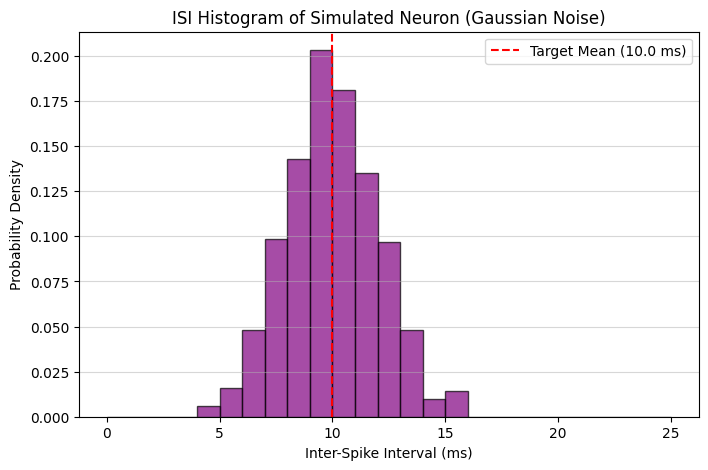

In [147]:
# Goal: Avoid large loop to check when we are exactly surpassing 5000 ms 
# 5000 ms / 10ms (expected ISI) = 500 => expect to need 500 samples but due to noise likely not exactly 
# drawing more and later cutting where it goes over 
exp_mean = 10
exp_std = 2
custom_isi_large = np.random.normal(exp_mean,exp_std,600) # going until 600 should guarantee that I surpass 5000 ms 

custom_isi_large[custom_isi_large <= 0] = 0.001 # ensures no negative or plateau isi 
custom_firing_large = np.cumsum(custom_isi_large) # converts isi to spike times 
custom_firing = custom_firing_large[custom_firing_large <= 5000] # truncates firing rates to observational period 
custom_isi = custom_firing[1:] - custom_firing[:-1]


# # plotting 
# Visual Check (Histogram)
plt.figure(figsize=(8, 5))

# Define 1ms bins for high resolution => follow previous convention
max_bin = np.max(custom_isi) + 10
bins_1ms = np.arange(0, max_bin, 1)

plt.hist(custom_isi, bins=bins_1ms, density=True, color="purple", edgecolor="black", alpha=0.7)
# add horiziontal line to showcase expected isi
plt.axvline(exp_mean, color="r", linestyle="--", label=f"Target Mean ({exp_mean:.1f} ms)")

plt.title("ISI Histogram of Simulated Neuron (Gaussian Noise)")
plt.xlabel("Inter-Spike Interval (ms)")
plt.ylabel("Probability Density")
plt.legend()
plt.grid(axis="y", alpha=0.5)
plt.show()

The synthetic neuron most closely resembles Neuron B, as its ISI histogram shows a single, Gaussian-like peak centered around 10 ms, reflecting regular firing with temporal variability. Unlike Neuron A, which has no variability, and Neuron C, which shows multiple discrete peaks due to bursting, this neuron exhibits a continuous distribution of ISIs. Increasing the standard deviation broadens the histogram and lowers the central peak, indicating greater noise in spike timing.

Question 2:

In [148]:
# load data using try 
def load_data(file_path):
    try:
        df = pd.read_csv(file_path)
        print("Dataset loaded successfully.")
        return df
    except FileNotFoundError:
        print(f"Error: '{file_path}' not found. Please ensure the file is in the correct directory.")
        return None # Return None if loading failed

laptop_df = load_data("laptop_price - dataset.csv")
if laptop_df is None:
    exit()

Dataset loaded successfully.


In [149]:
# checking for empty values etc 
missing_counts = laptop_df.isnull().sum()
columns_with_missing = missing_counts[missing_counts > 0]
if columns_with_missing.empty:
    print("No columns have missing values")
else: 
    print("Columns with missing values and their counts:")
    print(columns_with_missing)
laptop_df.info()

No columns have missing values
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1275 entries, 0 to 1274
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Company              1275 non-null   object 
 1   Product              1275 non-null   object 
 2   TypeName             1275 non-null   object 
 3   Inches               1275 non-null   float64
 4   ScreenResolution     1275 non-null   object 
 5   CPU_Company          1275 non-null   object 
 6   CPU_Type             1275 non-null   object 
 7   CPU_Frequency (GHz)  1275 non-null   float64
 8   RAM (GB)             1275 non-null   int64  
 9   Memory               1275 non-null   object 
 10  GPU_Company          1275 non-null   object 
 11  GPU_Type             1275 non-null   object 
 12  OpSys                1275 non-null   object 
 13  Weight (kg)          1275 non-null   float64
 14  Price (Euro)         1275 non-null   float64
dtypes: floa

In [150]:

# cleaning column names to avoid issues down the road due to whitespaces etc
import re

def clean_column_names(df):
    
    df.columns = (
        df.columns
        .str.strip()
        .str.lower()
        .str.replace(r'[\s\(\)]+', '_', regex=True) # replaces spacing and brackets with a single _ not indivually so price_euro and not price__euro_
        .str.strip('_')                             # remove leading/trailing _
    )
    return df

laptop_df = clean_column_names(laptop_df)
print(laptop_df.head())

  company      product   typename  inches                    screenresolution  \
0   Apple  MacBook Pro  Ultrabook    13.3  IPS Panel Retina Display 2560x1600   
1   Apple  Macbook Air  Ultrabook    13.3                            1440x900   
2      HP       250 G6   Notebook    15.6                   Full HD 1920x1080   
3   Apple  MacBook Pro  Ultrabook    15.4  IPS Panel Retina Display 2880x1800   
4   Apple  MacBook Pro  Ultrabook    13.3  IPS Panel Retina Display 2560x1600   

  cpu_company       cpu_type  cpu_frequency_ghz  ram_gb               memory  \
0       Intel        Core i5                2.3       8            128GB SSD   
1       Intel        Core i5                1.8       8  128GB Flash Storage   
2       Intel  Core i5 7200U                2.5       8            256GB SSD   
3       Intel        Core i7                2.7      16            512GB SSD   
4       Intel        Core i5                3.1       8            256GB SSD   

  gpu_company                gpu

Plotting the price of all laptops. Using a histogram to observe the shape of the distribution (expect right skeweness, some very expensive laptops) and a boxplot, to clearly see potential outliers,

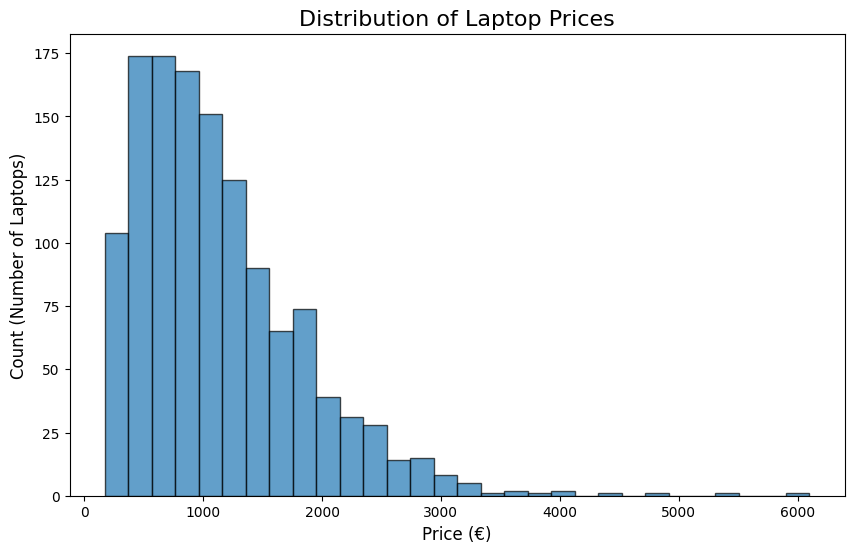

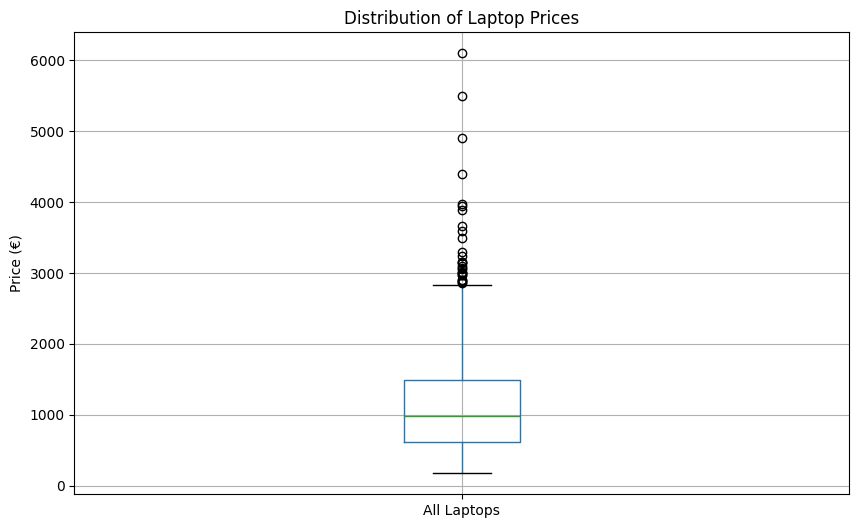

In [151]:
plt.figure(figsize=(10, 6))

laptop_df["price_euro"].hist(bins=30, edgecolor="black", alpha=0.7, grid=False)
plt.title("Distribution of Laptop Prices", fontsize=16)
plt.xlabel("Price (€)", fontsize=12)
plt.ylabel("Count (Number of Laptops)", fontsize=12)
plt.show()
# highly skewed to the right => makes sense lots of cheaper laptops and a few very expensive // no obvious worng inputs (e.g., price = 1)
plt.figure(figsize=(10, 6))

# boxplot ==> only outliers to the right as we have seen with the histogram 


laptop_df.boxplot(column=["price_euro"])
plt.xticks([1], ["All Laptops"])  # Replace the tick label
plt.ylabel("Price (€)")
plt.title("Distribution of Laptop Prices")
plt.show()

As expected the distribution of prices is skewed to the right and importantly there seems to be no obvious input errors (e.g., price of 1 or 100k).

In [152]:
# Average prices per company and the most expensive company
mean_prices = laptop_df.groupby("company")["price_euro"].mean().reset_index(name='mean_price')
mean_prices_sorted = mean_prices.sort_values(by='mean_price', ascending=False) # most expensive on top
print(mean_prices_sorted)

most_expensive_company = mean_prices_sorted["company"].iloc[0] # Access the company on top 
max_price = mean_prices_sorted["mean_price"].iloc[0] # Access the price on top
print(f"Most expensive Company: {most_expensive_company}, Average Price: {max_price:.2f}")


      company   mean_price
14      Razer  3346.142857
9          LG  2099.000000
11        MSI  1728.908148
6      Google  1677.666667
13  Microsoft  1612.308333
1       Apple  1564.198571
8      Huawei  1424.000000
15    Samsung  1413.444444
16    Toshiba  1267.812500
4        Dell  1199.225120
18     Xiaomi  1133.462500
2        Asus  1123.829737
10     Lenovo  1093.862215
7          HP  1080.314664
5     Fujitsu   729.000000
0        Acer   633.464455
3       Chuwi   314.296667
12   Mediacom   295.000000
17       Vero   217.425000
Most expensive Company: Razer, Average Price: 3346.14


In [163]:
# Operating systems 
# unique entries before 
print(laptop_df["opsys"].unique())

# rename the Operating system to group the same ones 
renaming_dict = {
    "macOS" : "Mac",
    "Mac OS X" : "Mac",
    "No OS" : "No OS", 
    "Windows 10" : "Windows",
    "Windows 10 S" : "Windows",
    "Linux" : "Linux",
    "Android" : "Android", 
    "Chrome OS" : "Chrome", 
    "Windows 7" : "Windows"
}
laptop_df["opsys"] = laptop_df["opsys"].replace(renaming_dict)
unique_OS = laptop_df["opsys"].unique()
print(unique_OS)
print(laptop_df.groupby("opsys").size())

['Mac' 'No OS' 'Windows' 'Linux' 'Android' 'Chrome']
['Mac' 'No OS' 'Windows' 'Linux' 'Android' 'Chrome']
opsys
Android       2
Chrome       27
Linux        58
Mac          21
No OS        66
Windows    1101
dtype: int64


Distribution of laptop price stratified by the different Operating Systems. Boxplots: 

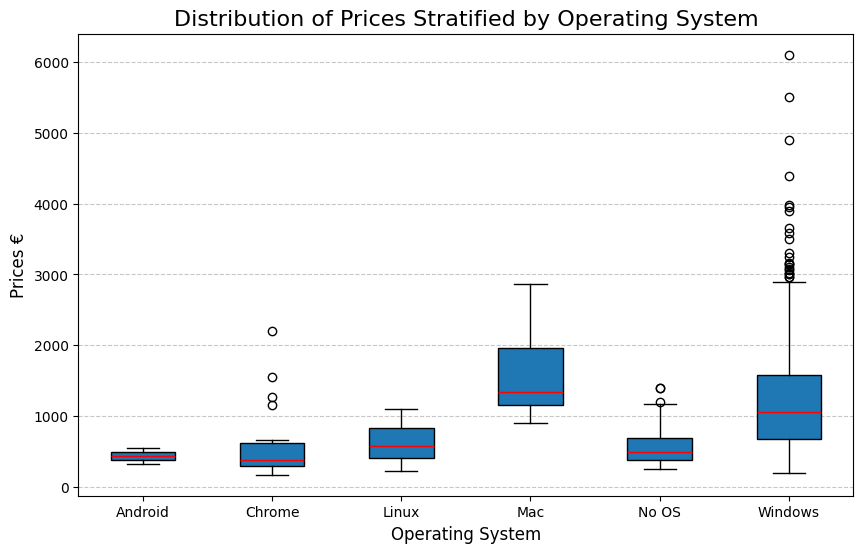

In [154]:
# group the laptops with the same operating system and get the prices and companies
grouped_data = laptop_df.groupby("opsys")["price_euro"].apply(list)
plot_prices = grouped_data.values # all the prices 
plot_labels = grouped_data.index.tolist() # all the different operating systems

plt.figure(figsize=(10, 6))

plt.boxplot(
    plot_prices,
    tick_labels=plot_labels,
    patch_artist=True,  
    medianprops=dict(color="red") 
)

plt.title("Distribution of Prices Stratified by Operating System", fontsize=16)
plt.xlabel("Operating System", fontsize=12)
plt.ylabel("Prices €", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

Distribution of laptop price stratified by the different Operating Systems. Histograms: 

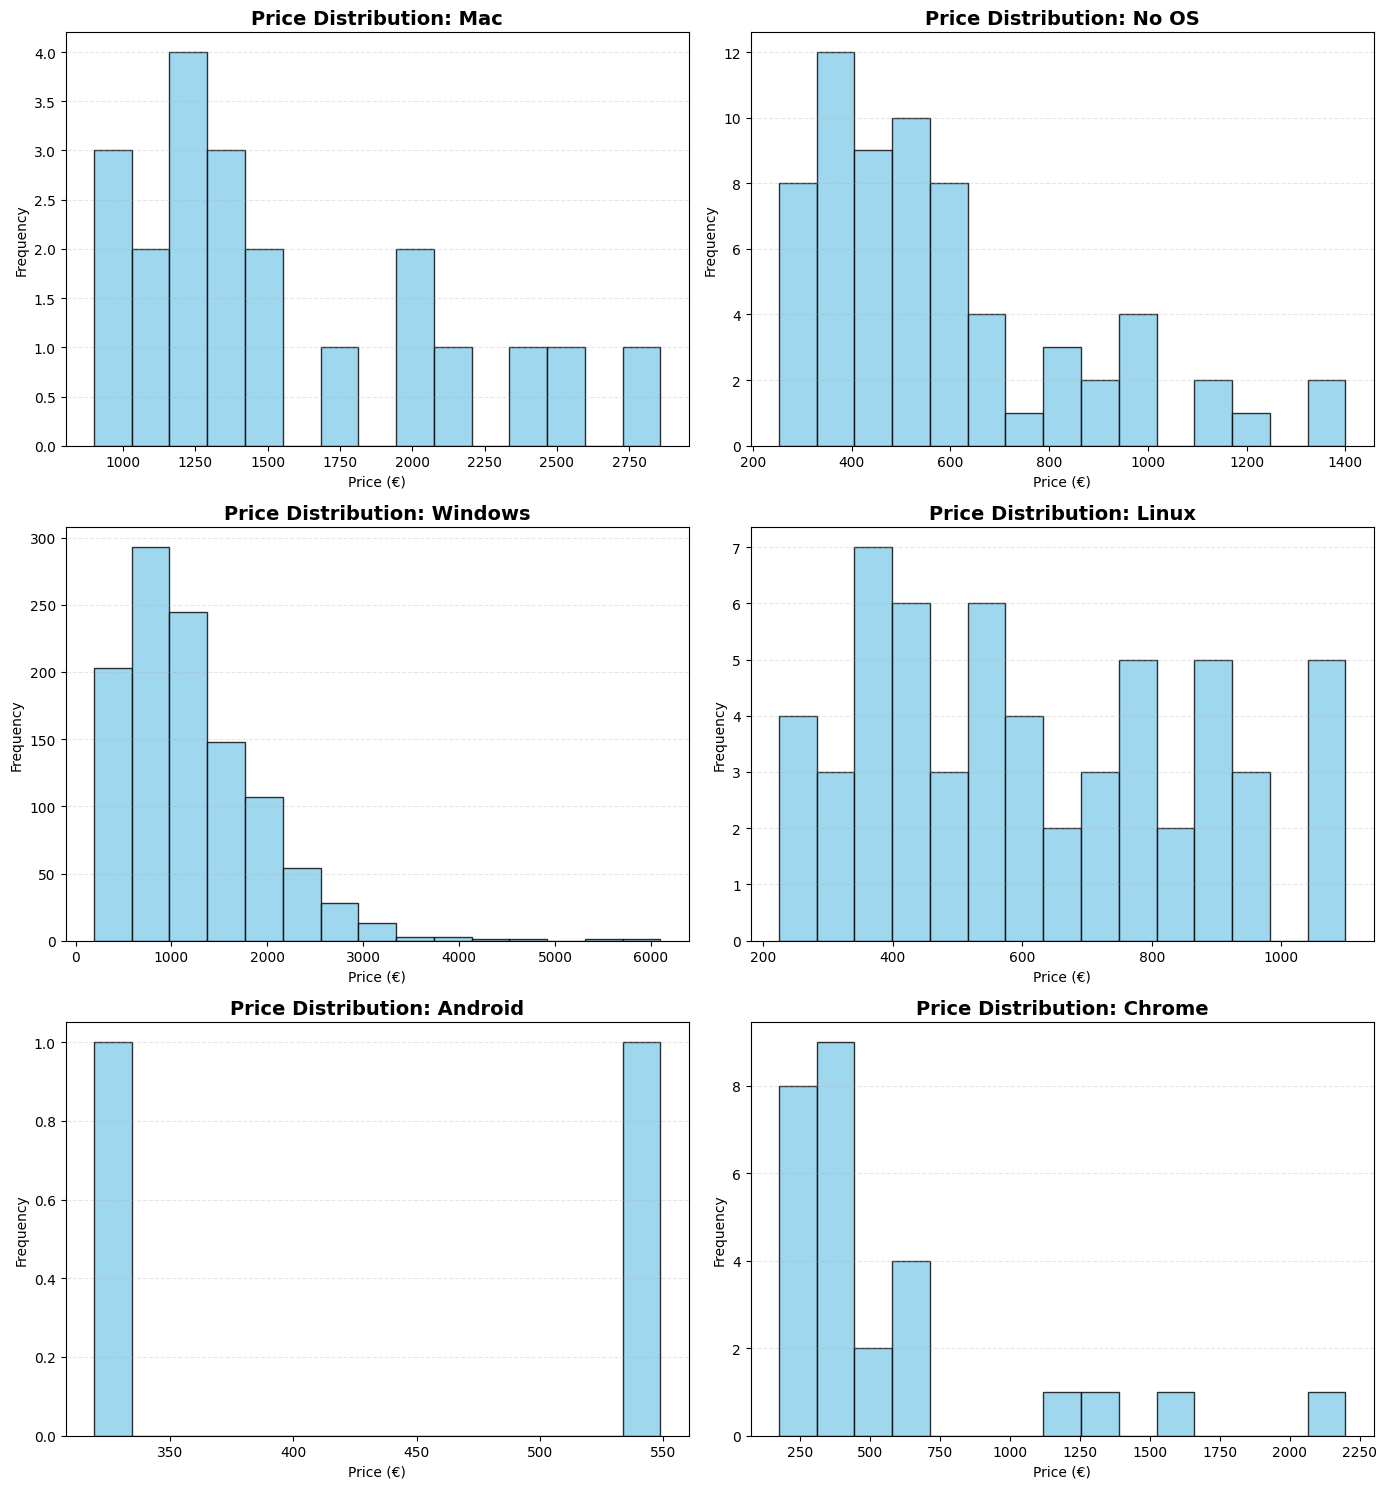

In [ ]:
# Histogram for each operating system
fig, axes = plt.subplots(3, 2, figsize=(14, 15))
axes = axes.flatten() #

for i, os_name in enumerate(unique_OS):
    # Filter data
    os_data = laptop_df[laptop_df["opsys"] == os_name]["price_euro"]
    
    # Plotting the histogram
    axes[i].hist(os_data, bins=15, color='skyblue', edgecolor='black', alpha=0.8)
    
    # Formatting of each subplot 
    axes[i].set_title(f"Price Distribution: {os_name}", fontsize=14, fontweight='bold')
    axes[i].set_xlabel("Price (€)", fontsize=10)
    axes[i].set_ylabel("Frequency", fontsize=10) 
    axes[i].grid(axis="y", linestyle="--", alpha=0.3)


plt.tight_layout()
plt.show()

Windows laptops dominate the dataset, while all other operating systems have very small sample sizes. Box plots and histograms rely on having enough data points to meaningfully estimate distributions. For categories like Android (n=2) or Mac (n=21), the box plot statistics (quartiles, whiskers) are  misleading, and histograms become extremely sensitive to bin choices. However, there arent any real graph alternatives, that can showcase/approximate the true distribution well with such small sample size.

Relationship between Price and Ram (GB).

/var/folders/nt/4mfx9gh57lbclgx07g4mjzgm0000gn/T/ipykernel_98426/3503684998.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(data=laptop_df, x="ram_gb", y="price_euro", jitter=0.2, alpha=0.7, palette="viridis")


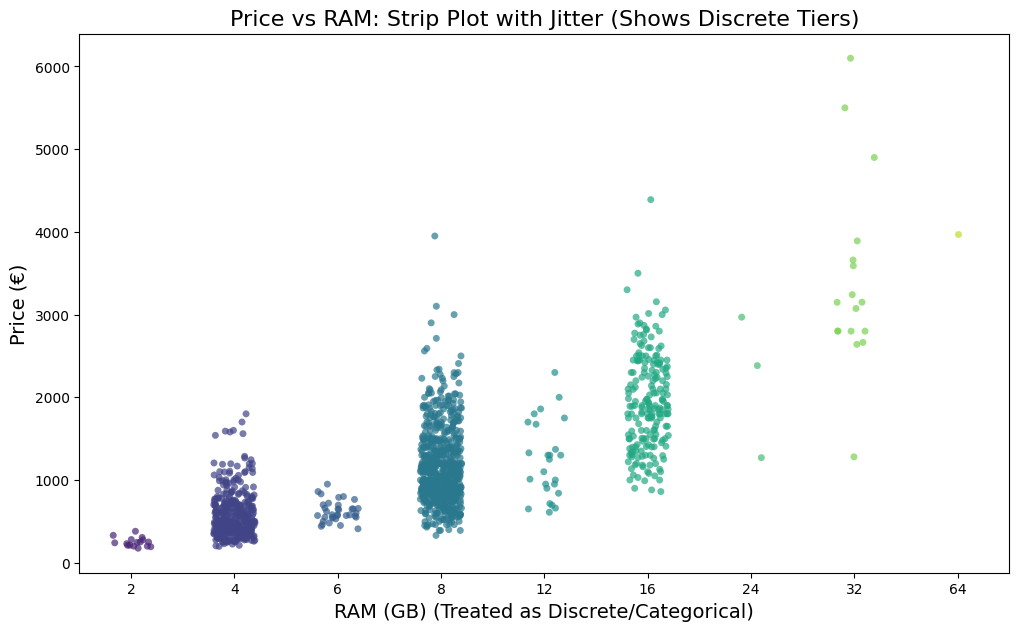

In [155]:
# Plot price and ram 
# utilize jitter because ram is an integer and we want to actually see the distribution and not just overlap 
plt.figure(figsize=(12, 7))
sns.stripplot(data=laptop_df, x="ram_gb", y="price_euro", jitter=0.2, alpha=0.7, palette="viridis")
plt.title("Price vs RAM: Strip Plot with Jitter (Shows Discrete Tiers)", fontsize=16)
plt.xlabel("RAM (GB) (Treated as Discrete/Categorical)", fontsize=14)
plt.ylabel("Price (€)", fontsize=14)
plt.show()


We see a non-linear positive relationship between ram and price. It makes sense, that for larger ram the price increases and that the increase is not linear increasing an already high ram is likely more expensive and valuable.

Outliers are laptops that deviate strongly from the general trend between RAM and price. Since high price may correspond to high RAM, univariate outliers (just a high price) are not necessarily multivariate outliers. Therefore we cannot use the boxplots and IQR that we have seen previously. We can model the relationship between Ram and price using OLS regression and can find potential outliers by looking at points that are unusual (high residual error) and that strongly influence the fitted trend (using cooks distance). However as we havse seen, price is not normally distributed, meaning that we have to utilize the log transformation in order to fit OLS regression. 

Strategy:
Fit OLS regression predicting log price by RAM. => Find influential points  => Create a table of residuals per point and their level of influence => One can indiviudally check points that exhibit strong residuals and influence or set a predefined threshhold as to what an outlier is.

In [156]:
# new dataframe for regression where additional columns will be added 
laptop_df_reg = laptop_df.copy() 
laptop_df_reg["log_price"] = np.log(laptop_df_reg["price_euro"]) # logarithmic transformation
laptop_df_reg["ram_gb"] = laptop_df_reg["ram_gb"].astype("float") 

#fitting the model 
# exploratory analysis and outlier detection not predictive modeling therefore I dont need to do train test split etc
formula_robust = "log_price ~ ram_gb"
model_robust = sm.ols(formula_robust, data=laptop_df_reg).fit()


influence = OLSInfluence(model_robust)
laptop_df_reg["cooks_d"] = influence.cooks_distance[0]
n = len(laptop_df_reg)
threshold = 4 / n # Common rule of thumb for establishing influential points 

influential_points = laptop_df_reg[laptop_df_reg["cooks_d"] > threshold]

# summary of influential points 
print(f"Outlier Detection Method: Cook's Distance (Threshold: {threshold:.4f})")
print(f"Number of Influential Points: {len(influential_points)} ({(len(influential_points)/n * 100):.2f}% of data)")
print(model_robust.summary().as_text())




Outlier Detection Method: Cook's Distance (Threshold: 0.0031)
Number of Influential Points: 39 (3.06% of data)
                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.464
Model:                            OLS   Adj. R-squared:                  0.463
Method:                 Least Squares   F-statistic:                     1100.
Date:                Fri, 19 Dec 2025   Prob (F-statistic):          2.30e-174
Time:                        16:39:26   Log-Likelihood:                -801.56
No. Observations:                1275   AIC:                             1607.
Df Residuals:                    1273   BIC:                             1617.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------

In [ ]:
# Creating an outlier report 
laptop_df_reg["standardized_residual"] = model_robust.resid_pearson / model_robust.scale**0.5 # raw residuals /std of residuals 
influential_points_details = laptop_df_reg[laptop_df_reg["cooks_d"] > threshold].copy() # only take the influential points 

# Add key prediction metrics to the filtered DataFrame
influential_points_details["Predicted_Log_Price"] = model_robust.predict(influential_points_details)
influential_points_details["Predicted_Price_Euro"] = np.exp(influential_points_details["Predicted_Log_Price"]) # add the actual predicted value: e^ of log predicted price 

# only pick relevant columns
outlier_report = influential_points_details[[
    "ram_gb",          
    "price_euro", 
    "Predicted_Price_Euro", 
    "standardized_residual", 
    "cooks_d"
]].sort_values(by="standardized_residual", key = abs, ascending=False) # focus on the largest anamolies (interested in abs prediction error)

# Rename columns for clear output
outlier_report.columns = [
    "RAM (GB)", 
    "Actual Price (€)", 
    "Predicted Price (€)", 
    "Std. Residual", 
    "Cook's D"
]

print("Outlier report")
print(outlier_report.to_string(float_format="%.2f")) # print actually all rows and not just some

Outlier report
      RAM (GB)  Actual Price (€)  Predicted Price (€)  Std. Residual  Cook's D
1066     64.00           3975.00             93915.57         -15.34      2.78
901      32.00           1279.00              6644.74          -7.99      0.12
1136      8.00           3949.40               911.55           7.11      0.00
1120      4.00            196.00               654.64          -5.85      0.00
791       4.00            202.90               654.64          -5.68      0.00
1215      2.00            174.00               554.77          -5.62      0.01
1102      4.00            209.00               654.64          -5.54      0.00
555       4.00            224.00               654.64          -5.20      0.00
20        2.00            191.90               554.77          -5.15      0.01
67        4.00            229.00               654.64          -5.09      0.00
290       2.00            199.00               554.77          -4.97      0.01
31        2.00            199.00     

By modeling the relationship between RAM and laptop price using an OLS regression on log(Price) and RAM, we can focus on the highest anomalies (largest absolute standardized residuals), for points that are influential for the fitted model. This approach is quite flexible, as we can decide, whether we set a predefined threshhold (e.g., standardized abs residual >= 3 for influential points) to classify them as outliers or we look at all of them on a case by case bases. 

Importantly, this approach builds on the assumption, that only RAM is relevant for the price (it clearly is not) and also rests on the assumptions of the fitted OLS model. 

Storage Type: Unsure what to do with cases like 256 SSD + 500GB HDD => could make two columns storage type 1 and 2 or combine them which would make it harder to work with down the road ==> Create two columns.

In [164]:
print(laptop_df["memory"].unique())

# getting the storage types 
def extract_both_storage_types(storage_string):
    parts = storage_string.split("+")  # for the edge cases with two storage types 

    def get_type(s): # for the first part 
        s = s.strip()
        storage_type = s.split(" ")[-1] # pick part after the white space ==> from 16GB SSD ==> SSD 
        
        # Handle Flash Storage edge case
        if "Flash" in s and storage_type == "Storage":
            return "Flash Storage"
        return storage_type
    first_type = get_type(parts[0])

    # extract second storage type if it exists 
    if len(parts) > 1:
        second_type = get_type(parts[1])
    else:
        second_type = None # no second storage tyoe => return none 

    # results as dictionary for easy column generation
    return {
        "first_storage_type": first_type,
        "second_storage_type": second_type
    }

df_results = laptop_df["memory"].map(extract_both_storage_types).apply(pd.Series) 
final_df = pd.concat([laptop_df, df_results], axis=1) # append the two new columns to existing df and create a new one 


['128GB SSD' '128GB Flash Storage' '256GB SSD' '512GB SSD' '500GB HDD'
 '256GB Flash Storage' '1TB HDD' '32GB Flash Storage'
 '128GB SSD +  1TB HDD' '256GB SSD +  256GB SSD' '64GB Flash Storage'
 '256GB SSD +  1TB HDD' '256GB SSD +  2TB HDD' '32GB SSD' '2TB HDD'
 '64GB SSD' '1.0TB Hybrid' '512GB SSD +  1TB HDD' '1TB SSD'
 '256GB SSD +  500GB HDD' '128GB SSD +  2TB HDD' '512GB SSD +  512GB SSD'
 '16GB SSD' '16GB Flash Storage' '512GB SSD +  256GB SSD'
 '512GB SSD +  2TB HDD' '64GB Flash Storage +  1TB HDD' '180GB SSD'
 '1TB HDD +  1TB HDD' '32GB HDD' '1TB SSD +  1TB HDD'
 '512GB Flash Storage' '128GB HDD' '240GB SSD' '8GB SSD' '508GB Hybrid'
 '1.0TB HDD' '512GB SSD +  1.0TB Hybrid' '256GB SSD +  1.0TB Hybrid']


Showcasing types of memory storage: Importanly a significant amount of laptops have two types.

In [168]:
print(final_df["first_storage_type"].value_counts(dropna=False))
print(final_df["second_storage_type"].value_counts(dropna=False))

first_storage_type
SSD              837
HDD              359
Flash Storage     71
Hybrid             8
Name: count, dtype: int64
second_storage_type
None      1067
HDD        202
SSD          4
Hybrid       2
Name: count, dtype: int64
